# Analisi avanzata per i supermercati BIO

I supermercati BIO sono un punto di riferimento per coloro che cercano prodotti biologici, sostenibili ed ecologici. Oltre agli alimenti biologici, i clienti trovano anche elettronica di consumo proveniente da marchi eco-friendly che utilizzano materiali riciclabili e adottano pratiche di produzione sostenibili. Inoltre, sono disponibili prodotti cosmetici e di bellezza, privi di ingredienti dannosi per la salute e l'ambiente.

L'obiettivo dell'analisi è sviluppare un modello di machine learning che aiuti la catena di supermercati BIO a predire la redditività attesa di un determinato acquisto.

Successivamente, si andrà ad analizzare verticalmente una determinata tipologia di prodotto venduta dalla catena, cioè le mele, per decidere quali tipologie potrebbero generare maggiori vendite.

Infine, si studierà l'evoluzione degli utili nel tempo tramite la costruzione di un modello basato sulle time series.


In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
regression_raw_dataset = pd.read_csv('C:\\Users\\vdibi\\Desktop\\MASTER IN DATA ANALYSIS\\8. MACHINE LEARNING\\supermarket_sales.csv')

# Esplorazione del dataset


In [3]:
regression_raw_dataset.head(100)

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,594-34-4444,A,Yangon,Normal,Male,Electronic accessories,97.16,1,4.8580,102.0180,3/8/2019,20:38,Ewallet,97.16,4.761905,4.8580,7.2
96,766-85-7061,B,Mandalay,Normal,Male,Health and beauty,87.87,10,43.9350,922.6350,3/29/2019,10:25,Ewallet,878.70,4.761905,43.9350,5.1
97,871-39-9221,C,Naypyitaw,Normal,Female,Electronic accessories,12.45,6,3.7350,78.4350,2/9/2019,13:11,Cash,74.70,4.761905,3.7350,4.1
98,865-92-6136,A,Yangon,Normal,Male,Food and beverages,52.75,3,7.9125,166.1625,3/23/2019,10:16,Ewallet,158.25,4.761905,7.9125,9.3


I metadati principali delle colonne del dataset sono:

In [8]:
regression_raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Total                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

Alcune colonne risultano poco utili ai fini dell'analisi per la predizione e quindi vanno eliminate.

In [11]:
regression_dataset = regression_raw_dataset.drop(columns=['Invoice ID', 'Tax 5%', 'Total', 'Date', 'Time', 'cogs', 'gross margin percentage'])

In [ ]:
regression_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Branch         1000 non-null   object 
 1   City           1000 non-null   object 
 2   Customer type  1000 non-null   object 
 3   Gender         1000 non-null   object 
 4   Product line   1000 non-null   object 
 5   Unit price     1000 non-null   float64
 6   Quantity       1000 non-null   int64  
 7   Payment        1000 non-null   object 
 8   gross income   1000 non-null   float64
 9   Rating         1000 non-null   float64
dtypes: float64(3), int64(1), object(6)
memory usage: 78.3+ KB


# Media, mediana, moda e deviazione standard

Si parte calcolando la media, la mediana e la moda della colonna su cui si andrà a fare predizioni ovvero sulla label **Rating**. Ai fini del progetto la colonna Rating acquisisce un significato differente rispetto a quello originale del dataset: essa dà una valutazione alla transazione in base alla redditività e quindi indica quanto è stata proficua la stessa per la catena di supermercati.

In [ ]:
# codice per calcolare la media, mediana e moda della label "Rating"

In [ ]:
mean_rating = regression_dataset['Rating'].mean()
median_rating = regression_dataset['Rating'].median()
mode_rating = regression_dataset['Rating'].mode()[0]

print(f"Media: {mean_rating}")
print(f"Mediana: {median_rating}")
print(f"Moda: {mode_rating}")

Media: 6.9727
Mediana: 7.0
Moda: 6.0


La **deviazione** è una importantissima misura di "sparsità" dei dati ed è una informazione molto utile da ottenere sulla label.

In [ ]:
# codice per calcolare la deviazione standard della label "Rating"

In [ ]:
std_rating = regression_dataset['Rating'].std()

print(f"Deviazione standard: {std_rating}")

Deviazione standard: 1.718580294379123


Una deviazione standard di 1,72 indica una moderata dispersione: i dati non sono né troppo vicini né troppo distanti tra loro.

# Come sono distribuiti i valori della label

A questo punto andiamo a vedere come sono graficamente distribuiti i dati:

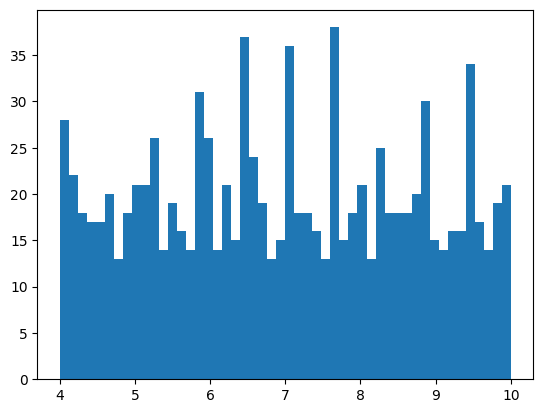

In [ ]:
plt.hist(regression_dataset['Rating'], 50)
plt.show()

La distribuzione dei rating è più o meno uniforme e non c'è skewness.

Il discorso è invece diverso per l'utile lordo:

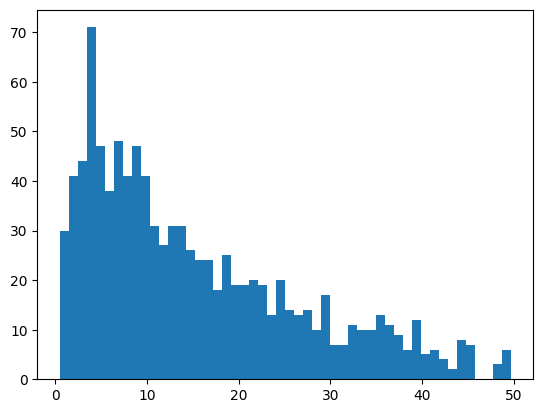

In [ ]:
plt.hist(regression_dataset['gross income'], 50)
plt.show()

Qui la skewness c'è e la maggioranza degli ordini sembra avere un income lordo basso.


In [ ]:
# Codice per calcolare la skewness del gross income

In [ ]:
skewness_gross_income = regression_dataset['gross income'].skew()

print(f"Skewness (asimmetria): {skewness_gross_income}")

Skewness (asimmetria): 0.8925698049581423


# Analisi esplorativa dei dati sulle vendite

Andiamo ad analizzare quali sono le città in cui si effettuano più introiti, quali sono le categorie che portano maggior valore
e se il sesso dell’acquirente fa differenza o meno sull'acquisto.


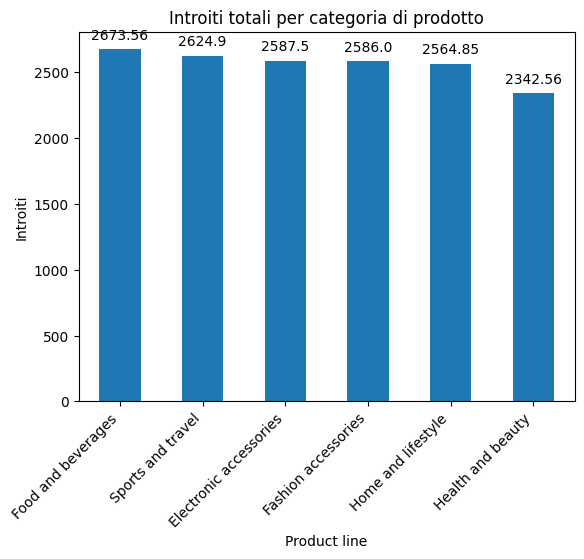

In [ ]:
import matplotlib.pyplot as plt

category_revenue = regression_dataset.groupby('Product line')['gross income'].sum().sort_values(ascending=False)

ax = category_revenue.plot(kind='bar')
plt.title('Introiti totali per categoria di prodotto')
plt.ylabel('Introiti')
plt.xticks(rotation=45, ha='right')

for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

In [ ]:
# Città con maggiori introiti

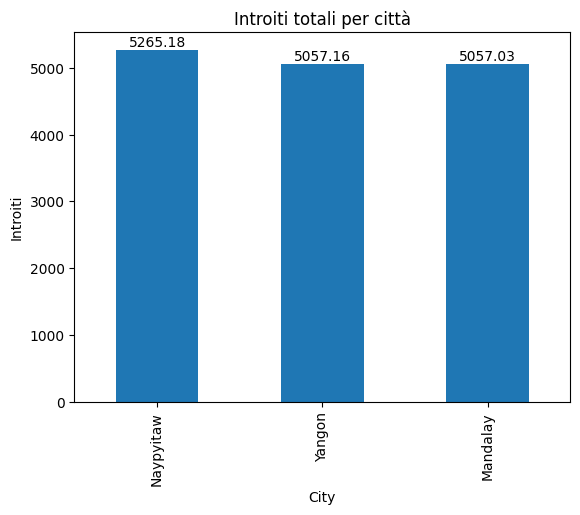

In [ ]:
import matplotlib.pyplot as plt

city_revenue = regression_dataset.groupby('City')['gross income'].sum().sort_values(ascending=False)

ax = city_revenue.plot(kind='bar')
plt.title('Introiti totali per città')
plt.ylabel('Introiti')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

In [ ]:
# Influenza del sesso dell'acquirente

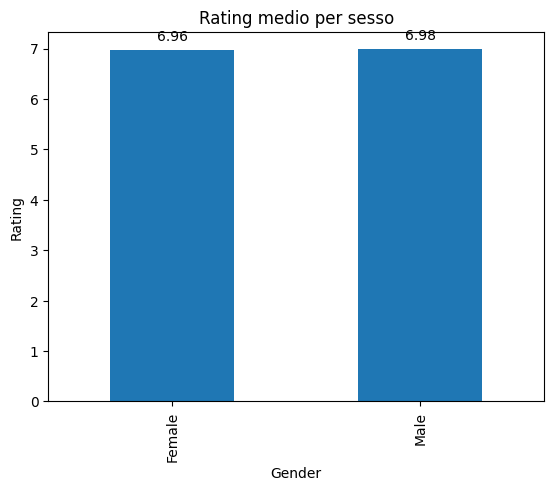

In [ ]:
import matplotlib.pyplot as plt

gender_rating = regression_dataset.groupby('Gender')['Rating'].mean()

ax = gender_rating.plot(kind='bar')
plt.title('Rating medio per sesso')
plt.ylabel('Rating')

for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

La città di Naypyitaw e la sezione Food & Bevarges sono le più redditizie. Per quanto riguarda il sesso dell'acquirente, la differenza tra i valori medi è molto piccola. Questo suggerisce che il sesso potrebbe non avere un'influenza significativa sul Rating.

# Encoding delle variabili categoriche

E' necessario utilizzare le **tecniche per effettuarne l'enconding** delle variabili (come "Branch", "City", "Customer type", "Gender", "Product line" e "Payment") che non sono numeriche e che quindi non possono essere direttamente usate dagli algoritmi.

In [ ]:
# codice per effettuare l'enconding delle variabili categoriche

In [13]:
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ["Branch", "City", "Customer type", "Gender", "Product line", "Payment"]
one_hot_encoder = OneHotEncoder()

# Applica il One-Hot Encoding
encoded_features = one_hot_encoder.fit_transform(regression_dataset[categorical_columns])

# Nomi delle nuove colonne
encoded_feature_names = one_hot_encoder.get_feature_names_out(categorical_columns)

# Creazione di un DataFrame con le colonne encodate
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoded_feature_names, index=regression_dataset.index)

# Concatena il DataFrame originale con le colonne encodate, eliminando le originali
final_dataset = pd.concat([regression_dataset.drop(columns=categorical_columns), encoded_df], axis=1)

print(final_dataset.head())

final_dataset.info()

   Unit price  Quantity  gross income  Rating  Branch_A  Branch_B  Branch_C  \
0       74.69         7       26.1415     9.1       1.0       0.0       0.0   
1       15.28         5        3.8200     9.6       0.0       0.0       1.0   
2       46.33         7       16.2155     7.4       1.0       0.0       0.0   
3       58.22         8       23.2880     8.4       1.0       0.0       0.0   
4       86.31         7       30.2085     5.3       1.0       0.0       0.0   

   City_Mandalay  City_Naypyitaw  City_Yangon  ...  Gender_Male  \
0            0.0             0.0          1.0  ...          0.0   
1            0.0             1.0          0.0  ...          0.0   
2            0.0             0.0          1.0  ...          1.0   
3            0.0             0.0          1.0  ...          1.0   
4            0.0             0.0          1.0  ...          1.0   

   Product line_Electronic accessories  Product line_Fashion accessories  \
0                                  0.0        

# Feature Scaling

Nel dataset ci sono alcune feature che potrebbero essere **standardizzate/normalizzate**: quelle più evidenti sono sicuramente il prezzo del singolo oggetto, ovvero "Unit price", e "gross income" che ha una grossa skewness.

In [ ]:
# codice per effettuare la standardizzazione della colonna "Unit price" e "gross income"

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
#Standardizzazione della colonna "Unit price" e "gross income"
final_dataset['Unit price'] = scaler.fit_transform(final_dataset[['Unit price']])
final_dataset['gross income'] = scaler.fit_transform(final_dataset[['gross income']])
print(final_dataset.head())


   Unit price  Quantity  gross income  Rating  Branch_A  Branch_B  Branch_C  \
0    0.718160         7      0.919607     9.1       1.0       0.0       0.0   
1   -1.525303         5     -0.987730     9.6       0.0       0.0       1.0   
2   -0.352781         7      0.071446     7.4       1.0       0.0       0.0   
3    0.096214         8      0.675780     8.4       1.0       0.0       0.0   
4    1.156959         7      1.267125     5.3       1.0       0.0       0.0   

   City_Mandalay  City_Naypyitaw  City_Yangon  ...  Gender_Male  \
0            0.0             0.0          1.0  ...          0.0   
1            0.0             1.0          0.0  ...          0.0   
2            0.0             0.0          1.0  ...          1.0   
3            0.0             0.0          1.0  ...          1.0   
4            0.0             0.0          1.0  ...          1.0   

   Product line_Electronic accessories  Product line_Fashion accessories  \
0                                  0.0        

# Train e Test Split

Bene, è quindi giunta l'ora di affrontare l'ultima fase prima di allenare un modello di machine learning: l**o split fra training e test set**!


In [ ]:
# codice per splittare il dataset in training set e test set

In [17]:
from sklearn.model_selection import train_test_split

X = final_dataset.drop(columns=["Rating"])
y = final_dataset["Rating"]

# Split del dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


X_train: (800, 22)
X_test: (200, 22)
y_train: (800,)
y_test: (200,)


# Linear Regression

Ora è giunto il momento di sviluppare il modello più semplice della linear regression. Il modello si chiamerà *regressor*.


In [ ]:
# training del modello con la linear regression

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Inizializza il modello di regressione lineare
regressor = LinearRegression()

# Esegui il training del modello
regressor.fit(X_train, y_train)

LinearRegression()

Adesso che il training è avvenuto è il momento di valutare come questo performa. Le metriche che prendiamo in considerazione sono **il mean squadred error, il mean absolute error (*MSE* e *MAE*) e R² (R-squared)**

In [21]:
y_pred = regressor.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE =', MSE, '\nMAE =', MAE)
print(f"R²: {r2}")

MSE = 3.110187291026072 
MAE = 1.5229214208487525
R²: -0.01381683650370702


In [70]:
from sklearn.feature_selection import f_regression

# Valutazione dell'importanza statistica delle feature
f_values, p_values = f_regression(X, y)
feature_importance = pd.DataFrame({"Feature": X.columns, "F-Value": f_values, "P-Value": p_values})
print(feature_importance.sort_values(by="F-Value", ascending=False))


                                Feature   F-Value   P-Value
4                              Branch_B  4.035658  0.044817
6                         City_Mandalay  4.035658  0.044817
5                              Branch_C  1.659170  0.198014
7                        City_Naypyitaw  1.659170  0.198014
15      Product line_Food and beverages  1.408879  0.235525
2                          gross income  1.327104  0.249597
17      Product line_Home and lifestyle  1.179050  0.277812
8                           City_Yangon  0.515139  0.473091
3                              Branch_A  0.515139  0.473091
10                 Customer type_Normal  0.356195  0.550762
9                  Customer type_Member  0.356195  0.550762
1                              Quantity  0.249673  0.617415
14     Product line_Fashion accessories  0.233980  0.628694
18       Product line_Sports and travel  0.214465  0.643391
13  Product line_Electronic accessories  0.159603  0.689608
20                  Payment_Credit card 

La maggior parte delle feature, come Unit price, Gender, Payment, Product line, ecc., ha valori P molto alti (P>0.2), suggerendo una bassa correlazione con il target.

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Seleziona le feature con P-Value < 0.2
selected_features = ["Branch_B", "City_Mandalay", "Branch_C", "City_Naypyitaw", "Product line_Food and beverages", "gross income"]

# Subset dei dati per training e test
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Inizializza il modello di regressione lineare
regressor = LinearRegression()

# Training del modello
regressor.fit(X_train_selected, y_train)

# Predizione sul set di test
y_pred = regressor.predict(X_test_selected)

# Calcolo delle metriche di valutazione
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Stampa delle metriche
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² (Coefficient of Determination): {r2}")



Mean Squared Error (MSE): 3.0890180999502173
Mean Absolute Error (MAE): 1.5195893169207344
R² (Coefficient of Determination): -0.006916389578922155


# Polynomial Regression

Per un'analisi completa è corretto sviluppare anche la polynomial regression. Il modello si chiamerà *regressor* e *poly_regressor* l'oggetto relativo alle feature polinomiali.

In [ ]:
# training del modello con la polynomial regression

In [67]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

poly_regressor = PolynomialFeatures(degree=4, include_bias=False)
X_train_poly = poly_regressor.fit_transform(X_train_selected)
X_test_poly = poly_regressor.transform(X_test_selected)

# Training del modello con termini polinomiali
regressor = LinearRegression()
regressor.fit(X_train_poly, y_train)

# Predizione e valutazione
y_pred_poly = regressor.predict(X_test_poly)

MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
r2_poly = r2_score(y_test, y_pred_poly)
print('MSE =', MSE, '\nMAE =', MAE)
print(f"Polynomial Regression R²: {r2_poly}")

MSE = 3.0890180999502173 
MAE = 1.5195893169207344
Polynomial Regression R²: -0.03873998972204218


Un R² di −0.0387 ottenuto aumentando il grado del polinomio indica che il modello non sta migliorando, anzi, potrebbe star peggiorando a causa di overfitting.

Per andare a predire il Rating di nuovi acquisti in base alle feature città e categorie di prodotti, possiamo utilizzare il modello di regressione lineare già addestrato. Il modello di regressione lineare ha un MSE e un MAE migliore rispetto alla regressione polinomiale.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder


# Seleziona le feature e il target
features = ['City', 'Product line']
target = 'Rating'
X = regression_dataset[features]
y = regression_dataset[target]

# Crea un OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Esegui l'encoding delle feature categoriche
X_encoded = encoder.fit_transform(X)

# Crea un nuovo DataFrame con le feature encodate
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(features), index=X.index)

# Dividi i dati in training set e test set
X_train, X_test, y_train, y_test = train_test_split(X_encoded_df, y, test_size=0.2, random_state=42)


# Addestra il modello di regressione lineare:

model = LinearRegression()
model.fit(X_train, y_train)


# Fai previsioni per nuovi acquisti:

# Crea un DataFrame con i dati del nuovo acquisto
new_purchase = pd.DataFrame({'City': ['Naypyitaw'], 'Product line': ['Food and beverages']})

# Esegui l'encoding delle feature categoriche del nuovo acquisto
new_purchase_encoded = encoder.transform(new_purchase)

# Crea un DataFrame con le feature encodate del nuovo acquisto
new_purchase_encoded_df = pd.DataFrame(new_purchase_encoded, columns=encoder.get_feature_names_out(features))

# Fai la previsione del Rating
predicted_rating = model.predict(new_purchase_encoded_df)

print(f"Il Rating previsto per il nuovo acquisto è: {predicted_rating[0]}")

Il Rating previsto per il nuovo acquisto è: 7.143414101722396


# Logistic Regression

In questa sezione si cambia dataset  (*classification_dataset*), in quanto cambia la natura del problema: si passa infatti a un problema di classificazione, in cui si andrà a valutare la qualità di alcune mele destinate alla catena di supermercati per decidere quali sono le mele di qualità migliore.

In [ ]:
# codice per importare il dataset apple_quality

In [72]:
classification_dataset = pd.read_csv('C:\\Users\\vdibi\\Desktop\\MASTER IN DATA ANALYSIS\\8. MACHINE LEARNING\\apple_quality.csv')

In [ ]:
# codice per print delle prime 50 righe

In [74]:
classification_dataset.head(50)

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good
5,5.0,-3.425400,-1.409082,-1.913511,-0.555775,-3.853071,1.914616,-2.981523169,bad
6,6.0,1.331606,1.635956,0.875974,-1.677798,3.106344,-1.847417,2.414170509,good
7,7.0,-1.995462,-0.428958,1.530644,-0.742972,0.158834,0.974438,-1.470125066,good
8,8.0,-3.867632,-3.734514,0.986429,-1.207655,2.292873,4.080921,-4.871904758,bad
9,9.0,-0.727983,-0.442820,-4.092223,0.597513,0.393714,1.620857,2.185607723,bad


... e dei metadati delle colonne:

In [ ]:
# codice per visualizzare i principali metadata del dataset apple_quality

In [ ]:
print(classification_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4001 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 281.4+ KB
None


In [ ]:
# codice per rimuovere la label "Acidity"

In [76]:
classification_dataset.drop('Acidity', axis=1, inplace=True)
print(classification_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Quality      4000 non-null   object 
dtypes: float64(7), object(1)
memory usage: 250.2+ KB
None


Il dataset ha quasi tutte le colonne
numeriche. L'unica a non esserlo è proprio la label 'Quality' , che va encodata:

In [ ]:
# codice per effettuare l'enconding della label "Quality"

In [78]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(classification_dataset[['Quality']])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['Quality']))
classification_dataset = pd.concat([classification_dataset, encoded_df], axis=1)
classification_dataset = classification_dataset.drop(columns=['Quality'])

In [80]:
#codice per cancellare i valori NaN
classification_dataset.dropna(inplace=True)
print(classification_dataset.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   A_id          4000 non-null   float64
 1   Size          4000 non-null   float64
 2   Weight        4000 non-null   float64
 3   Sweetness     4000 non-null   float64
 4   Crunchiness   4000 non-null   float64
 5   Juiciness     4000 non-null   float64
 6   Ripeness      4000 non-null   float64
 7   Quality_bad   4000 non-null   float64
 8   Quality_good  4000 non-null   float64
 9   Quality_nan   4000 non-null   float64
dtypes: float64(10)
memory usage: 343.8 KB
None


Bisogna poi ri-effettuare la divisione fra porzione di addestramento e porzione di test, usando la nomenclatura vista in precedenza:

In [ ]:
# codice per splittare in train/test il dataset apple_quality

In [82]:
from sklearn.model_selection import train_test_split
X = classification_dataset.drop(columns=['Quality_good', 'Quality_bad', 'A_id', 'Quality_nan'])
y = classification_dataset['Quality_good']  # Target: Quality_good

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (3200, 6)
X_test: (800, 6)
y_train: (3200,)
y_test: (800,)


Ora è giunto il momento di usare la logistic regression per allenare il modello vero e proprio, che si chiamerà *logistic_regressor*

In [ ]:
# codice per trainare il modello usando la logistic regression

In [84]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model
logistic_regressor = LogisticRegression()
# Train the model on the training data
logistic_regressor.fit(X_train, y_train)



LogisticRegression()

Una metrica che permette subito di valutare la bontà del modello è l'***F1 score***, che dovrebbe essere idealmente superiore a 0.80.

In [86]:
from sklearn.metrics import classification_report

y_pred = logistic_regressor.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.76      0.76       401
         1.0       0.76      0.77      0.77       399

    accuracy                           0.77       800
   macro avg       0.77      0.77      0.76       800
weighted avg       0.77      0.77      0.76       800



La **confusion matrix** mostra quali sono le categorie su cui il modello è "bravo" e su quali no, così da eventualmente avere delle informazioni in più per migliorarlo.

In [ ]:
# codice per la confusion matrix

In [88]:
from sklearn.metrics import confusion_matrix

# Matrice di confusione
confusion_mat = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', confusion_mat)


Confusion Matrix:
 [[305  96]
 [ 92 307]]


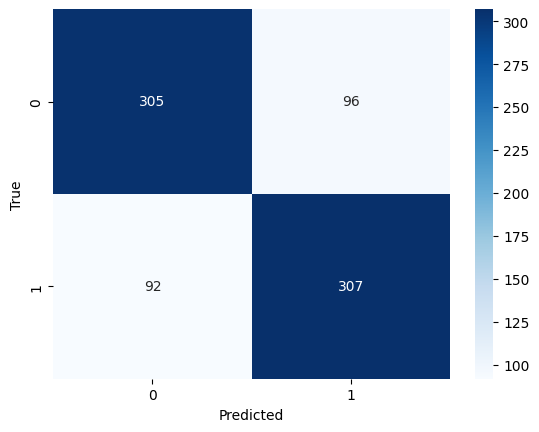

In [56]:
import seaborn as sns
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# identificare qual è il threshold migliore da usare per la Logistic Regression

In [90]:
from sklearn.metrics import f1_score

y_pred = logistic_regressor.predict_proba(X_test)[:, 1]
thresholds = np.linspace(0.1, 0.9, 9)
f1_scores = []

for threshold in thresholds:
    y_pred_threshold = (y_pred >= threshold).astype(int)
    score = f1_score(y_test, y_pred_threshold)
    f1_scores.append(score)

optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Threshold ottimale: {optimal_threshold}")
print(f"Punteggio F1: {max(f1_scores)}")

# Recompute predictions using the optimal threshold
y_pred_optimal = (y_pred >= optimal_threshold).astype(int)
print("Classification Report (Optimal Threshold):")
print(classification_report(y_test, y_pred_optimal))

Threshold ottimale: 0.4
Punteggio F1: 0.7757847533632287
Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

         0.0       0.83      0.63      0.72       401
         1.0       0.70      0.87      0.78       399

    accuracy                           0.75       800
   macro avg       0.76      0.75      0.75       800
weighted avg       0.76      0.75      0.75       800



In [ ]:
# Ottimizzazione di alcuni iperparametri come C, solver, and max_iter

In [92]:
from sklearn.model_selection import GridSearchCV

# Definisci la griglia di iperparametri da esplorare
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 500, 1000]
}

# Crea un modello di regressione logistica
logistic = LogisticRegression(random_state=42)

# Crea un oggetto GridSearchCV
grid_search = GridSearchCV(
    estimator=logistic,
    param_grid=param_grid,
    scoring='f1',  # Metrica di valutazione (in questo caso, F1-score)
    cv=5,          # Numero di fold per la cross-validation
    n_jobs=-1,     # Utilizza tutti i core disponibili
    verbose=1      # Mostra informazioni sullo stato della ricerca
)

# Esegui la ricerca sulla griglia
grid_search.fit(X_train, y_train)

# Ottieni il modello migliore
best_logistic = grid_search.best_estimator_

# Fai previsioni con il modello migliore
y_pred_best = best_logistic.predict(X_test)

# Stampa il report di classificazione
print("Classification Report (Optimized Logistic Regression):")
print(classification_report(y_test, y_pred_best))

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Classification Report (Optimized Logistic Regression):
              precision    recall  f1-score   support

         0.0       0.76      0.76      0.76       401
         1.0       0.76      0.76      0.76       399

    accuracy                           0.76       800
   macro avg       0.76      0.76      0.76       800
weighted avg       0.76      0.76      0.76       800



# Decision Tree

Usando un **decision tree** si potrebbe migliorare le prestazioni del modello basato su logistic regression.

In [ ]:
# training del modello con un decision tree

In [96]:
from sklearn.tree import DecisionTreeClassifier
decision_tree_classifier = DecisionTreeClassifier()
# traing the model
decision_tree_classifier.fit(X_train, y_train)
# previsioni sul test
y_pred = decision_tree_classifier.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.79      0.80      0.80       401
         1.0       0.80      0.79      0.79       399

    accuracy                           0.80       800
   macro avg       0.80      0.79      0.79       800
weighted avg       0.80      0.80      0.79       800



In [ ]:
# confusion matrix del decision tree

Confusion Matrix:
 [[320  81]
 [ 83 316]]


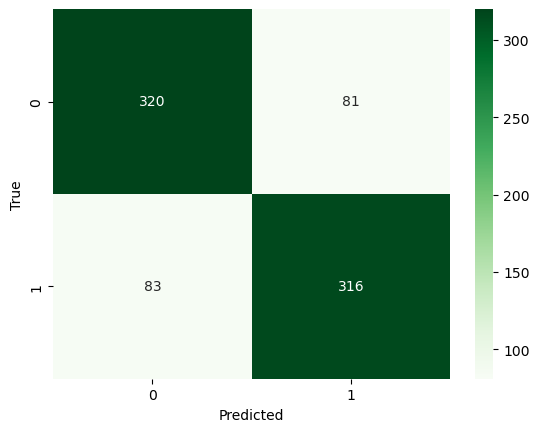

In [98]:
confusion_mat = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', confusion_mat)

import seaborn as sns
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Tramite il comando della **feature importance** si può capire quali sono le feature che sono state più importanti per il decision tree.

In [ ]:
# codice per la feature importance

In [100]:
feature_importances = decision_tree_classifier.feature_importances_
# Creazione di un DataFrame per visualizzare le feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
# Imposta il DataFrame per importanza
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

       Feature  Importance
5     Ripeness    0.218733
2    Sweetness    0.180530
0         Size    0.166217
4    Juiciness    0.149843
3  Crunchiness    0.145562
1       Weight    0.139115


In [ ]:
# usare un max_depth più alta

In [102]:
decision_tree_classifier = DecisionTreeClassifier(max_depth=10, random_state=42)

decision_tree_classifier.fit(X_train, y_train)

y_pred = decision_tree_classifier.predict(X_test)

print("Classification Report (Decision Tree with max_depth=10):")
print(classification_report(y_test, y_pred))

Classification Report (Decision Tree with max_depth=10):
              precision    recall  f1-score   support

         0.0       0.79      0.80      0.79       401
         1.0       0.79      0.78      0.79       399

    accuracy                           0.79       800
   macro avg       0.79      0.79      0.79       800
weighted avg       0.79      0.79      0.79       800



In [ ]:
# Addestrare e confrontare modelli con il criterio "gini" e "entropia"

In [104]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Train and evaluate with 'gini'
decision_tree_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
decision_tree_gini.fit(X_train, y_train)
y_pred_gini = decision_tree_gini.predict(X_test)

print("Classification Report (Decision Tree - Gini):")
print(classification_report(y_test, y_pred_gini))

# Train and evaluate with 'entropy'
decision_tree_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)
decision_tree_entropy.fit(X_train, y_train)
y_pred_entropy = decision_tree_entropy.predict(X_test)

print("Classification Report (Decision Tree - Entropy):")
print(classification_report(y_test, y_pred_entropy))


Classification Report (Decision Tree - Gini):
              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79       401
         1.0       0.79      0.79      0.79       399

    accuracy                           0.79       800
   macro avg       0.79      0.79      0.79       800
weighted avg       0.79      0.79      0.79       800

Classification Report (Decision Tree - Entropy):
              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81       401
         1.0       0.81      0.81      0.81       399

    accuracy                           0.81       800
   macro avg       0.81      0.81      0.81       800
weighted avg       0.81      0.81      0.81       800



Considerato che il modello di regressione logistica, anche dopo l'ottimizzazione degli iperparametri, non raggiunge un punteggio F1 migliore del modello di Decision Tree, possiamo dedurre che il modello di Decision tree sia una scelta migliore per la classificazione.

# K-Means Clustering
IL K-Means Clustering è il più utilizzato algoritimo tra quelli non supervisionati.

Per prima cosa bisogna eliminare la label 'Quality' perché il K-Means Clustering è un algoritmo non supervisionato e non deve quindi averla:

In [ ]:
print(classification_dataset.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   A_id          4000 non-null   float64
 1   Size          4000 non-null   float64
 2   Weight        4000 non-null   float64
 3   Sweetness     4000 non-null   float64
 4   Crunchiness   4000 non-null   float64
 5   Juiciness     4000 non-null   float64
 6   Ripeness      4000 non-null   float64
 7   Quality_bad   4000 non-null   float64
 8   Quality_good  4000 non-null   float64
 9   Quality_nan   4000 non-null   float64
dtypes: float64(10)
memory usage: 343.8 KB
None


In [ ]:
clustering_dataset = classification_dataset.drop(columns=['Quality_bad', 'Quality_good','A_id','Quality_nan'])

In [ ]:
print(clustering_dataset.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 0 to 3999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         4000 non-null   float64
 1   Weight       4000 non-null   float64
 2   Sweetness    4000 non-null   float64
 3   Crunchiness  4000 non-null   float64
 4   Juiciness    4000 non-null   float64
 5   Ripeness     4000 non-null   float64
dtypes: float64(6)
memory usage: 218.8 KB
None


In [ ]:
# codice per trainare il modello con K-Means Clustering

Affinche K-Means funzioni in modo efficace bisogna standardizzare le feature nel clustering_dataset.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(clustering_dataset)

Provando a settare il modello dapprima con un numero di cluster pari a 2, questo non predice in modo corretto la qualità della mela. Il modello, invece, funziona correttamente settando un numero di cluster pari a 3, facendo così scoprire che in realtà ci sono anche delle mele di qualità intermedia.

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

KMeans(n_clusters=3, random_state=42)

Effettuo quindi una predizione per vedere a che qualità corrisponde la mela data in input al modello.

In [ ]:
# Impostazione valori per ciascuna feature della mela
Size = -0.292024
Weight = -1.351282
Sweetness = -1.738429
Crunchiness = -0.342616
Juiciness = 2.838636
Ripeness = -0.038033


# Creazione di un DataFrame per le feature della nuova mela
new_apple_features = pd.DataFrame(
    [[Size, Weight, Sweetness, Crunchiness, Juiciness, Ripeness]],
    columns=clustering_dataset.columns)

new_apple_features_scaled = scaler.transform(new_apple_features)
predicted_cluster = kmeans.predict(new_apple_features_scaled)[0]

In [ ]:
quality_mapping = {0: 'Qualità non buona', 1: 'Qualità buona', 2: 'Qualità media'}
predicted_quality = quality_mapping[predicted_cluster]
print(f"La qualità prevista della mela è: {predicted_quality}")
print(f"Cluster assegnato alla mela: {predicted_cluster}")

La qualità prevista della mela è: Qualità non buona
Cluster assegnato alla mela: 0


Dopo aver addestrato il modello, esaminiamo le caratteristiche medie delle mele in ciascun cluster.
Il cluster con i valori medi più alti identifica una tipologia di mela migliore come qualità.

In [ ]:
for i in range(kmeans.n_clusters):
       print(f"Cluster {i}:")
       print(clustering_dataset[kmeans.labels_ == i].mean())

Cluster 0:
Size          -0.518401
Weight        -1.008377
Sweetness     -1.921323
Crunchiness    0.247877
Juiciness      0.519904
Ripeness       2.138901
dtype: float64
Cluster 1:
Size          -1.580861
Weight        -0.730633
Sweetness      1.097829
Crunchiness    0.492247
Juiciness      1.484287
Ripeness      -0.294598
dtype: float64
Cluster 2:
Size           0.631822
Weight        -1.241601
Sweetness     -0.777860
Crunchiness    2.171189
Juiciness     -0.505896
Ripeness      -0.173788
dtype: float64


 Il Cluster 1 sembra avere i valori medi più alti per la maggior parte delle feature desiderabili, come dolcezza, croccantezza e succosità.

Pertanto, in base a questa analisi, il Cluster 1 potrebbe rappresentare in media le mele di qualità migliore.

# Time Series

In questo scenario vogliamo provare a **capire come i gross income evolvono nel tempo**, quindi partendo dal dataset originale, ovvero *regression_raw_dataset* ed eliminando tutte le colonne, tenendo solo "Date" e "gross income". Il nuovo dataset si chiamerà *timeseries_dataset*.

In [ ]:
# codice per costruire un nuovo dataset, partendo da regression_raw_dataset, con solo le colonne "Date" e "gross income"

In [ ]:
print(regression_raw_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Total                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

In [ ]:
timeseries_dataset = regression_raw_dataset.drop(columns=['Invoice ID', 'Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Unit price', 'Quantity', 'Tax 5%', 'Total', 'Time', 'Payment', 'cogs', 'gross margin percentage','Rating'])

In [ ]:
timeseries_dataset.head(100)

,Date,gross income
0,1/5/2019,26.1415
1,3/8/2019,3.8200
2,3/3/2019,16.2155
3,1/27/2019,23.2880
4,2/8/2019,30.2085
...,...,...
95,3/8/2019,4.8580
96,3/29/2019,43.9350
97,2/9/2019,3.7350
98,3/23/2019,7.9125


A questo punto proviamo a utilizzare la **linear regression** su questa serie temporale, nello stesso modo di quanto già fatto in precedenza:

In [ ]:
# training della time series con la linear regression

In [ ]:
from sklearn.linear_model import LinearRegression
# Create a linear regression model
linear_regressor = LinearRegression()
# Train the model on the training data
linear_regressor.fit(X_train, y_train)

LinearRegression()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_pred = linear_regressor.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)

print('MSE =', MSE, '\nMAE =', MAE)

MSE = 0.1803298856039157 
MAE = 0.3730669505394964


Le metriche MSE e MAE non sono così elevati come in precedenza, questo perché la regressione lineare sulle time series spesso fallisce e c'è bisogno di altri modelli più perfomanti.

# Time Series con XGBoost

Un modello più performante è XGBoost.

In [ ]:
# training e performance evalutation della time series con XGBoost

MSE = 209.16244780350354 
MAE = 11.626365137748719


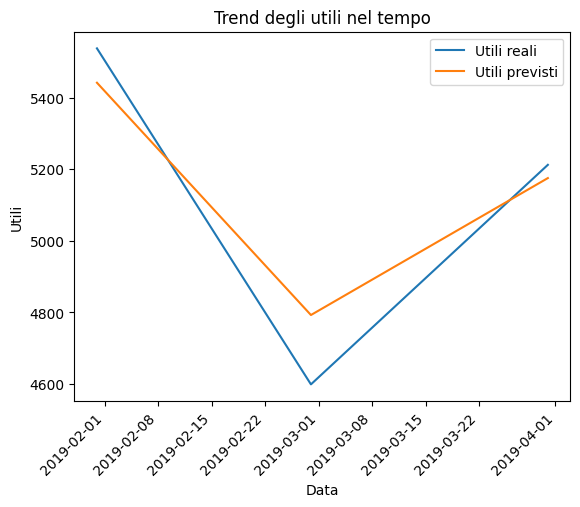

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 1. Prepara i dati:

# Crea un nuovo dataset con "Date" e "gross income"
timeseries_dataset = regression_raw_dataset[['Date', 'gross income']].copy()
timeseries_dataset['Date'] = pd.to_datetime(timeseries_dataset['Date'])  # Converti "Date" in datetime
timeseries_dataset.set_index('Date', inplace=True)  # Imposta "Date" come indice

# Crea feature temporali (ad esempio, mese, giorno della settimana)
timeseries_dataset['Month'] = timeseries_dataset.index.month
timeseries_dataset['DayOfWeek'] = timeseries_dataset.index.dayofweek

# Crea la feature target (utili futuri) - ad esempio, utili del giorno successivo
timeseries_dataset['FutureGrossIncome'] = timeseries_dataset['gross income'].shift(-1)
timeseries_dataset.dropna(inplace=True)

# Seleziona le feature e il target
features = ['gross income', 'Month', 'DayOfWeek']
target = 'FutureGrossIncome'
X = timeseries_dataset[features]
y = timeseries_dataset[target]

# Dividi i dati in training set e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 2. Addestra il modello XGBoost:

model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)


# 3. Fai previsioni e valuta il modello:

y_pred = model.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)

print('MSE =', MSE, '\nMAE =', MAE)


# 4. Analizza il trend:

# Fai previsioni sull'intero dataset
timeseries_dataset['PredictedGrossIncome'] = model.predict(timeseries_dataset[features])

# Aggrega i dati per mese
monthly_data = timeseries_dataset.resample('ME').sum()  # 'M' per mensile, 'W' per settimanale

# Visualizza il trend mensile
plt.plot(monthly_data.index, monthly_data['gross income'], label='Utili reali')
plt.plot(monthly_data.index, monthly_data['PredictedGrossIncome'], label='Utili previsti')

# Visualizza il trend
plt.title('Trend degli utili nel tempo')
plt.xlabel('Data')
plt.ylabel('Utili')
plt.legend()
plt.xticks(rotation=45, ha='right')  # Ruota di 45 gradi e allinea a destra
plt.show()

Il modello XGBoost ha appreso dai dati storici e ha cercato di identificare pattern e relazioni tra gli utili passati e gli utili futuri.Tuttavia, poiché le previsioni sono superiori agli utili reali, significa che il modello non sta catturando completamente la complessità del fenomeno.